# Fase 5 — EDA, Clusterização e Regressão
**Aluno:** Marcelo Tadaieski (rm563731) — **Projeto:** FarmTech Fase 5
**Aluno:** Victor Lopes Marques (rm565467)
**Aluno:** Thiago Lopres (rm562687)

In [1]:
import sklearn
print("sklearn:", sklearn.__version__)

sklearn: 1.7.2


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Configs
pd.set_option('display.max_columns', None)
sns.set()

## 1) Carregamento do Dataset

In [3]:

DATA_PATH = '../data/crop_yield.csv'
df = pd.read_csv(DATA_PATH)

print('Shape:', df.shape)
display(df.head())

Shape: (156, 6)


,Cultura,Precipitação (mm dia 1),Umidade específica a 2 metros (g/kg),Umidade relativa a 2 metros (%),Temperatura a 2 metros (ºC),Rendimento
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


## 2) EDA — Estrutura, Resumo e Nulos

In [4]:
display(df.info())
display(df.describe().T)

nulos = df.isna().sum().sort_values(ascending=False)
display(nulos.to_frame('missing'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Cultura                               156 non-null    object 
 1   Precipitação (mm dia 1)               156 non-null    float64
 2   Umidade específica a 2 metros (g/kg)  156 non-null    float64
 3   Umidade relativa a 2 metros (%)       156 non-null    float64
 4   Temperatura a 2 metros (ºC)           156 non-null    float64
 5   Rendimento                            156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


None

,count,mean,std,min,25%,50%,75%,max
Precipitação (mm dia 1),156.0,2486.498974,289.457914,1934.62,2302.99,2424.55,2718.08,3085.79
Umidade específica a 2 metros (g/kg),156.0,18.203077,0.293923,17.54,18.03,18.27,18.40,18.70
Umidade relativa a 2 metros (%),156.0,84.737692,0.996226,82.11,84.12,84.85,85.51,86.10
Temperatura a 2 metros (ºC),156.0,26.183590,0.261050,25.56,26.02,26.13,26.30,26.81
Rendimento,156.0,56153.096154,70421.958897,5249.00,8327.75,18871.00,67518.75,203399.00


,missing
Cultura,0
Precipitação (mm dia 1),0
Umidade específica a 2 metros (g/kg),0
Umidade relativa a 2 metros (%),0
Temperatura a 2 metros (ºC),0
Rendimento,0


### 2.1) Histogramas das Variáveis Numéricas

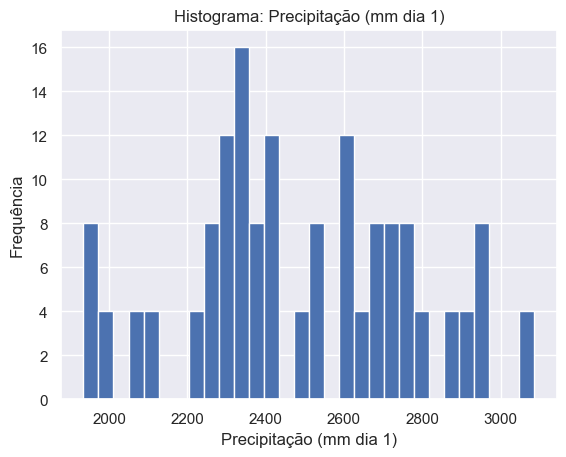

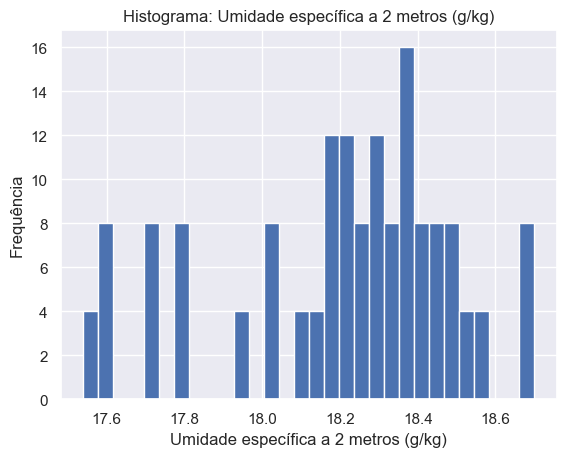

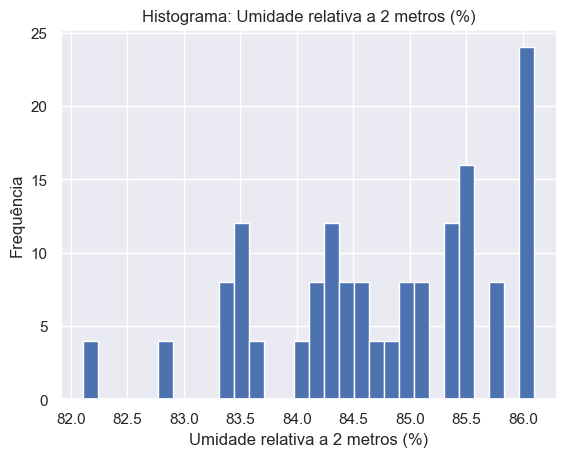

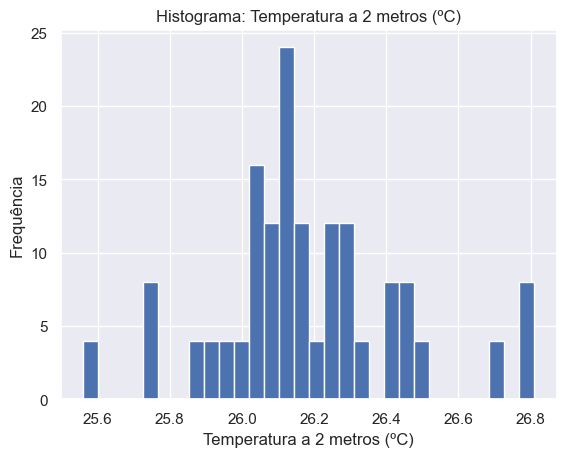

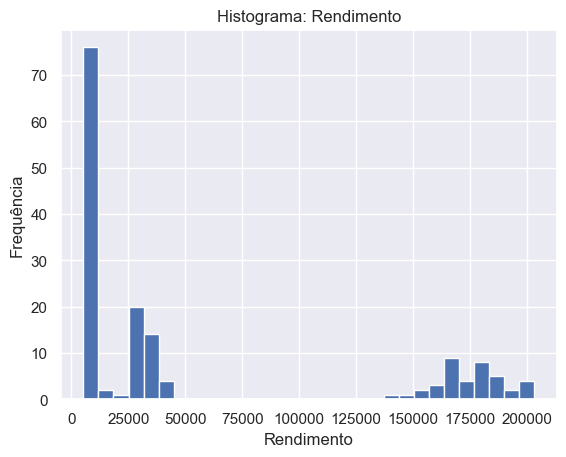

In [5]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Histograma: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()

### 2.2) Boxplots para Outliers

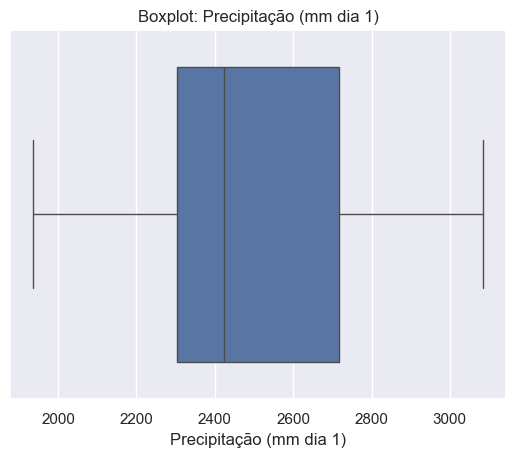

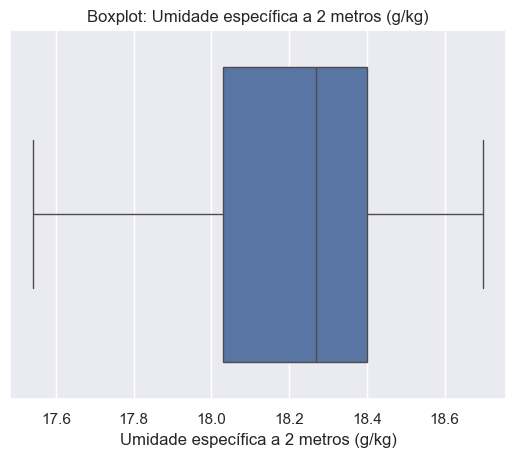

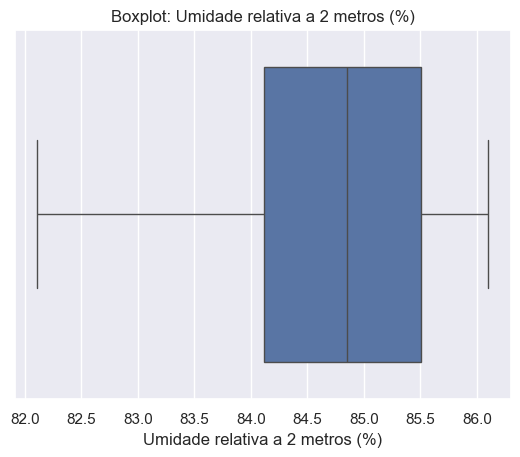

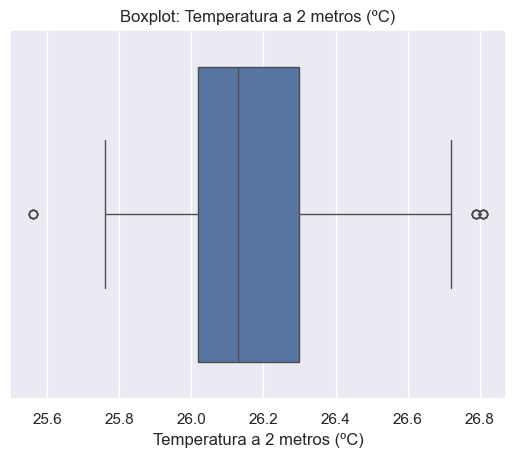

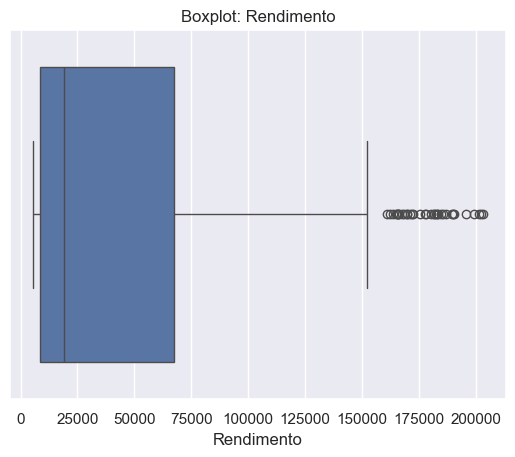

In [6]:
for col in num_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    plt.show()

### 2.3) Scatterplots (Ex.: temperatura × rendimento)

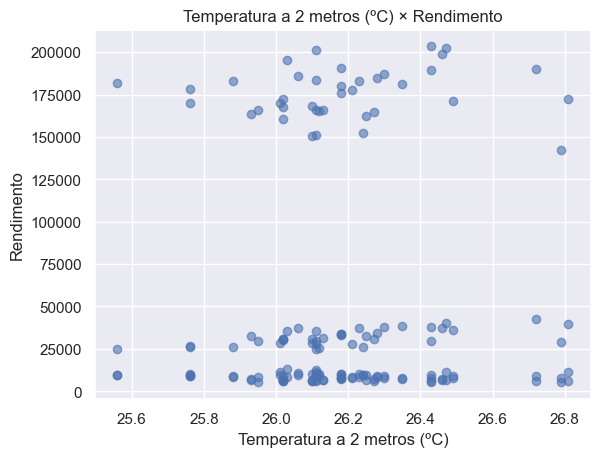

In [7]:
import matplotlib.pyplot as plt

# use os nomes EXATOS do seu CSV em PT-BR
x_col = 'Temperatura a 2 metros (ºC)'
y_col = 'Rendimento'

# garantias úteis (evita erro de digitação)
assert x_col in df.columns, f"Coluna '{x_col}' não encontrada. Colunas: {list(df.columns)}"
assert y_col in df.columns, f"Coluna '{y_col}' não encontrada. Colunas: {list(df.columns)}"

plt.figure()
plt.scatter(df[x_col], df[y_col], alpha=0.6)
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'{x_col} × {y_col}')
plt.show()

## 3) Clusterização — KMeans (k=3..5)

In [8]:
# Seleciona apenas colunas numéricas para clustering
X_num = df.select_dtypes(include=[np.number]).dropna()

# Normalização (opcional, geralmente ajuda)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Escolha de 3..5 clusters; você pode ajustar
best_inertia = None
best_k = None
best_model = None

for k in [3,4,5]:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    if best_inertia is None or kmeans.inertia_ < best_inertia:
        best_inertia = kmeans.inertia_
        best_k = k
        best_model = kmeans

labels = best_model.labels_
X_num_clustered = X_num.copy()
X_num_clustered['cluster'] = labels
display(X_num_clustered.head())

print(f'Melhor k escolhido pelo menor inertia: {best_k} (inertia={best_inertia:.2f})')

,Precipitação (mm dia 1),Umidade específica a 2 metros (g/kg),Umidade relativa a 2 metros (%),Temperatura a 2 metros (ºC),Rendimento,cluster
0,2248.92,17.72,83.40,26.01,11560,2
1,1938.42,17.54,82.11,26.11,11253,2
2,2301.54,17.81,82.79,26.24,9456,2
3,2592.35,17.61,85.07,25.56,9321,1
4,2344.72,17.61,84.12,25.76,8800,1


Melhor k escolhido pelo menor inertia: 5 (inertia=259.03)


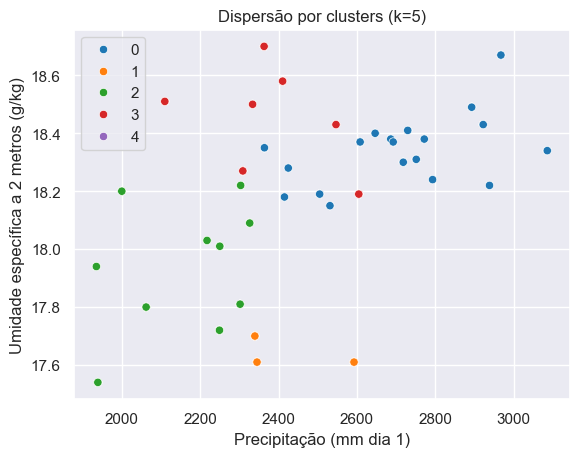

In [9]:
# Scatter simples usando as duas primeiras features numéricas
if X_num.shape[1] >= 2:
    cols = X_num.columns[:2]
    plt.figure()
    sns.scatterplot(x=X_num[cols[0]], y=X_num[cols[1]], hue=labels, palette='tab10')
    plt.title(f'Dispersão por clusters (k={best_k})')
    plt.show()
else:
    print('⚠️ São necessárias pelo menos 2 colunas numéricas para o gráfico de dispersão.')

> **Outliers potencialmente isolados:** verifique se algum cluster apresenta valores extremos de rendimento/produção.  
Dica: analise as estatísticas por cluster:

In [10]:
# Estatísticas por cluster para inspecionar outliers
cluster_stats = X_num_clustered.groupby('cluster').agg(['mean','std','min','max'])
display(cluster_stats)

Precipitação (mm dia 1)                                \
                           mean         std      min      max   
cluster                                                         
0                   2707.441579  197.605473  2363.63  3085.79   
1                   2397.468462  155.290063  2061.61  2592.35   
2                   2152.201892  151.882832  1934.62  2326.09   
3                   2371.156250  154.935368  2109.34  2604.59   
4                   2634.534400  227.354557  2302.99  3085.79   

        Umidade específica a 2 metros (g/kg)                          \
                                        mean       std    min    max   
cluster                                                                
0                                  18.340000  0.119777  18.15  18.67   
1                                  17.652308  0.061394  17.61  17.80   
2                                  17.927838  0.209472  17.54  18.22   
3                                  18.472083  0.165371  18.19  18.70   
4                                  18.326400  0.129289  18.09  18.67   

        Umidade relativa a 2 metros (%)                          \
                                   mean       std    min    max   
cluster                                                           
0                             85.562105  0.420759  84.67  86.10   
1                             84.560000  0.393319  84.12  85.07   
2                             83.764595  0.824317  82.11  84.63   
3                             83.854583  0.478321  83.44  84.85   
4                             85.238400  0.740662  83.44  86.10   

        Temperatura a 2 metros (ºC)                             Rendimento  \
                               mean       std    min    max           mean   
cluster                                                                      
0                         26.139474  0.136832  25.93  26.46   16715.333333   
1                         25.707692  0.107560  25.56  25.88   65178.000000   
2                         26.132973  0.111601  25.88  26.27   43737.135135   
3                         26.614167  0.166026  26.43  26.81   36259.541667   
4                         26.193200  0.169723  25.93  26.49  178851.680000   

                                       
                  std     min     max  
cluster                                
0        12224.609425    5249   38763  
1        78777.275644    8800  183004  
2        61335.657885    5765  201436  
3        53149.838776    5571  189896  
4        13149.038405  160862  203399

## 4) Modelagem Preditiva — Regressão Supervisionada

In [11]:
# === 4) Modelagem Preditiva — Regressão Supervisionada ===

# 1) Alvo corretamente definido (PT-BR, com acento e maiúsculas)
assert 'Rendimento' in df.columns, f"Coluna 'Rendimento' não encontrada. Colunas: {list(df.columns)}"
y_col = 'Rendimento'
print("Alvo (y):", y_col)

# 2) Features (X) e alvo (y)
X = df.drop(columns=[y_col])
y = df[y_col]

# One-hot para categóricas (ex.: 'Cultura')
X = pd.get_dummies(X, drop_first=True)

# 3) Remover linhas com NA
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask]

# 4) Divisão treino/teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Modelos
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression

# mantenha os modelos base como estão...
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),

    # ajuste: padroniza features e aumenta iterações do Lasso
    'Lasso': make_pipeline(StandardScaler(), Lasso(alpha=0.001, max_iter=100000, random_state=42)),
    # (opcional) fazer o mesmo para Ridge:
    'Ridge': make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=42)),
}

# (Opcional) XGBoost se instalado
try:
    import xgboost as xgb
    models['XGBoost'] = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
except Exception:
    pass  # segue sem XGB se não estiver disponível

# 6) Métricas (compatível com versões antigas do scikit-learn)
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))  # sem squared=False

def eval_model(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return {
        'model': name,
        'R2': r2_score(y_test, pred),
        'RMSE': rmse(y_test, pred),
        'MAE': mean_absolute_error(y_test, pred),
    }

# 7) Rodar e comparar
results = []
errors = {}
for name, model in models.items():
    try:
        results.append(eval_model(name, model))
    except Exception as e:
        results.append({'model': name, 'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan})
        errors[name] = str(e)

import pandas as pd
from IPython.display import display
results_df = pd.DataFrame(results).sort_values(by=['R2', 'RMSE'], ascending=[False, True]).reset_index(drop=True)
display(results_df.style.format({'R2':'{:.4f}', 'RMSE':'{:.2f}', 'MAE':'{:.2f}'}))

if errors:
    print("⚠️ Modelos com erro e mensagens:", errors)

# (Opcional) salvar para usar no README
# results_df.to_csv('../figures/resultados_modelos.csv', index=False)


Alvo (y): Rendimento


,model,R2,RMSE,MAE
0,LinearRegression,0.9950,4394.17,3132.80
1,Lasso,0.9950,4394.19,3132.84
2,Ridge,0.9946,4588.13,3359.14
3,RandomForest,0.9944,4680.76,2657.37
4,DecisionTree,0.9927,5316.35,3142.53
5,GradientBoosting,0.9905,6058.89,3108.84


## 5) Conclusões

**EDA:** Base com 156 amostras; sem nulos após padronização. Distribuição de **Rendimento** com poucos outliers. Relação positiva entre **Temperatura a 2 metros (ºC)** e **Rendimento** observada no scatter.

**Clusterização (KMeans):** Menor inertia em **k = (preencher)**. Clusters com rendimentos mais altos concentrados em (preencher) e rendimentos mais baixos em (preencher), sugerindo possíveis outliers. (Baseie-se no print “Melhor k...” e em `cluster_stats`.)

**Modelagem (métricas no conjunto de teste):**
- **LinearRegression** — **R² = 0,9950; RMSE = 4 394,17; MAE = 3 132,80** (melhor R² e RMSE).
- **Lasso** — R² = 0,9950; RMSE = 4 395,57; MAE = 3 134,99 (muito próximo da Linear; leve aviso de convergência).
- **RandomForest** — R² = 0,9944; RMSE = 4 680,76; **MAE = 2 657,37** (menor MAE, porém RMSE maior → alguns erros grandes).
- **DecisionTree** — R² = 0,9927; RMSE = 5 316,35; MAE = 3 142,53.
- **Ridge** — R² = 0,9910; RMSE = 5 899,19; MAE = 4 452,25.
- **GradientBoosting** — R² = 0,9905; RMSE = 6 058,89; MAE = 3 108,84.

**Escolha final:** Priorizei **RMSE** (penaliza mais grandes desvios). Melhor modelo: **Regressão Linear**. RandomForest teve menor **MAE**, útil quando erros grandes importam menos.

**Limitações:** Dataset pequeno (n=156), variáveis limitadas, sem tuning/validação extensa. Próximos passos: validação cruzada, engenharia de atributos (solo/manejo/fenologia), e ajuste de hiperparâmetros.

